In [1]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.utils.data as Data
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
import scipy.io
from VAE import myVAE
from classifier_cnn import addNoise2Batch
from GAN_PA_updatedRFF import getACC

In [5]:
batch_size=128
seed=0
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

PATH="../../../RFF-RL/TcasRFFData/"
dataFile="ChipCAIRprocessedType3BlockOS20len800comb220V1p2Quant16.npz"
file = np.load(PATH+dataFile)
items = file.files
items = file.files
datasets_all, targets_all = file[items[0]], file[items[1]]

sigmas=[1,2,3]

path_dict_load = np.load("./checkpoint2/gan/gan_vae_PA_fixed/plot_path_dict.npy", allow_pickle=True)
path_dict_load = path_dict_load.item()  
snrs = list(path_dict_load.keys())
acc_simgas = np.zeros((len(snrs), 220, len(sigmas)))
rfflabels = list(path_dict_load[snrs[0]])

for snri in range(len(snrs)):
    snr = snrs[snri]
    print("---------------SNR:{}dB-----------------".format(snr))
    
    for rfflabel in rfflabels:
        ckp_path = path_dict_load[snr][rfflabel]['ckp']
        file = ckp_path.split("/")[-1]
        rfflabel_load = int(file.split('_')[0][3:])
        assert rfflabel == rfflabel_load
        with open(ckp_path, 'rb') as ckp:
            gan_load = torch.load(ckp)
        generator=gan_load['generator']
        discriminator=gan_load['discriminator']
        classifier=gan_load['classifier']
        trainAcc = float(file.split("_")[3][8:])
        valAcc = float(file.split("_")[4][6:])
        trainBiAcc = float(file.split("_")[5][10:])
        valBiAcc = float(file.split("_")[6].split(".")[0][8:])
        # print("rfflabel:{}, trainAcc:{}, valAcc:{}, trainBiAcc:{}, valBiAcc:{}".format(rfflabel, trainAcc, valAcc, trainBiAcc, valBiAcc))
        
        datasets = torch.zeros((730, 2, 800))
        targets = torch.zeros((730, 12))
        datasets = datasets_all[rfflabel*730:(rfflabel+1)*730]
        datasets=addNoise2Batch(datasets, snr=snr, norm=False, device=device)
        targets = targets_all[rfflabel*730:(rfflabel+1)*730]
        for i in range(targets.shape[0]-1):
            if (targets[i]!=targets[i+1]).all():
                print("!!!Target error!!!")
        datasets, targets = torch.tensor(datasets), torch.tensor(targets)

        input_dim=1
        for i in range(1, len(datasets.shape)):
            input_dim=input_dim*datasets.shape[i]

        rffDataset=Data.TensorDataset(datasets, targets)
        len_rffdataset = len(rffDataset)
        r_train, r_val = 0.6, 0.4
        len_trainset = int(np.ceil(r_train*len_rffdataset))
        len_valset = len_rffdataset - len_trainset
        rffTrain, rffVal = Data.random_split(rffDataset, [len_trainset, len_valset], generator=torch.Generator().manual_seed(seed))
        trainLoader = Data.DataLoader(rffTrain, batch_size=batch_size, shuffle=True, drop_last=True, generator=torch.Generator().manual_seed(seed))
        valLoader = Data.DataLoader(rffVal, batch_size=batch_size, shuffle=True, drop_last=True, generator=torch.Generator().manual_seed(seed))

        # Test valLoader
        val_acc=[[] for _ in range(len(sigmas))]

        for batch_idx, (data_test, labels_test) in enumerate(valLoader):
            data_test, labels_test = data_test.to(device, dtype=torch.float), labels_test.to(device,  dtype=torch.float)

            # Train generator
            fake_out_g_test, mu_test, logvar_test = generator.forward(data_test) #if pretrained else generator.forward(data_test, device=device)
            
            for sigmai in range(len(sigmas)):
                sigma = sigmas[sigmai]
                z= generator.reparametrize(mu=mu_test, logvar=logvar_test, sigma=sigma)

                zReal= torch.cat((z, generator.txReal), dim=-1)
                zImag= torch.cat((z, generator.txImag), dim=-1)
                z_tx = torch.stack((zReal, zImag)).permute((1,0,2))
                data_test_hat = generator.decoder(z_tx)
                labels_ = classifier.forward(data_test_hat)
                val_acc[sigmai]+=getACC(labels_, labels_test)

        for sigmai in range(len(sigmas)):
            acc_simgas[snri][rfflabel][sigmai] = max(sum(val_acc[sigmai])/len(val_acc[sigmai]), acc_simgas[snri][rfflabel][sigmai])
    
    acc_simgas_mean = np.mean(acc_simgas, axis=1)
    print("acc_simgas: {}".format(acc_simgas_mean[snri]))

np.save("./checkpoint2/gan/gan_vae_PA_fixed/acc_sigmas.npy", acc_simgas)

---------------SNR:35dB-----------------


EOFError: Ran out of input

In [8]:
seeds=[0, 128]
snrs=[35, 30, 25, 20, 15, 10, 5]
error_ckp=[]
for snr in snrs:
    path="./checkpoint2/gan/gan_vae_PA_fixed/snr"+str(snr)+"/"
    folders = os.listdir(path)
    for folder in folders:
        if folder[:4]=="seed" and int(folder.split(".")[0][4:]) in seeds:
            for ckp_file in os.listdir(path+folder+'/ckp'):
                try:
                    ckp_load = torch.load(path+folder+'/ckp/'+ckp_file)
                except EOFError:
                    error_ckp.append(path+folder+'/ckp/'+ckp_file)

print(len(error_ckp))

RuntimeError: PytorchStreamReader failed reading file data/30: file read failed

In [12]:
print(snri, rfflabel, sigmai)
print(acc_simgas.shape)
print(len(val_acc))

6 2 2
(6, 220, 3)
3


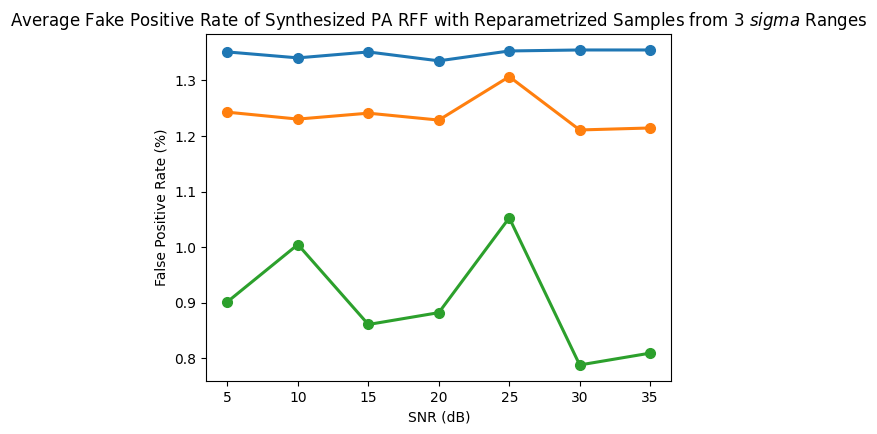

In [16]:
fig1, ax1 = plt.subplots(figsize=(6, 4.5))
acc_simgas_mean = np.mean(acc_simgas, axis=1)
for sigmai in range(len(sigmas)):
    ax1.plot(snrs, 100*acc_simgas_mean[:,sigmai], marker='o', linewidth=2.2, markersize=7, label=r'$\sigma${}'.format(sigmas[sigmai]))
    # ax1.set_ylim([0, 100])
    ax1.set_xticks(snrs)
    ax1.set_xlabel("SNR (dB)")
    ax1.set_ylabel("False Positive Rate (%)")
    ax1.set_title("Average Fake Positive Rate of Synthesized PA RFF with Reparametrized Samples from 3 $sigma$ Ranges")